In [6]:
%load_ext autoreload
%autoreload 2

# standard stuff
import os
import pandas as pd
import numpy as np
np.random.seed(123)
import json
import pickle 
from time import time
from tqdm import tqdm
import datetime as dt
from collections import Counter


# text processing
import re
with open('stopwords-de_no-parties.json', 'r') as file:
    stopwords_de = json.load(file)
from  nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")
import spacy
nlp = spacy.load('de')


# visualization 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Gensim LDA
from gensim import corpora
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

# custom imports
from data_handling import load_data, collapse_dfs
from text_preprocessing import df_processing, party_removerg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
read_in = False
path = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/lda_data.pickle'
parties = ['AfD', 'SPD', 'CDU', 'CSU', 'FDP', 'LINKE', 'Gruene', 'Grüne']
dates = ['08-{:02d}'.format(i) for i in range(2,10)]


if read_in:
    parties = parties
    dates = dates
    aug_data = {}
    print('Loading: {}'.format(dates))
    for party in parties:
        load_list = ['../Data/{}/{}_2018-{}.json'.format(party, party, day) for day in dates]
        aug_data[party] = load_data(load_list)
        print('{} loaded'.format(party))
    with open(path, 'wb') as fid:
        pickle.dump(aug_data, fid)
    print("Done")
else:
    print('loading data from pickle')
    with open(path, 'rb') as fid:
        aug_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


In [3]:
collapse = False
path_collapse = '/home/franzi/Git-DSR/Twitter_sentimentanalysis/Data/all_data_lda.pickle' # path where pickle file is saved

if collapse:
    all_data = collapse_dfs(aug_data)
    df_processing(all_data)
    all_data = all_data.drop_duplicates('clean_text')
    all_data['user_id'] = all_data.loc[:, 'user'].map(lambda x: x['id_str'])
    all_data.drop('user', inplace=True, axis=1)
    print('dumping data to pickle')
    with open(path_collapse, 'wb') as fid:
        pickle.dump(all_data, fid)
    print('data dumped')
else: 
    print('loading data from pickle')
    with open(path_collapse, 'rb') as fid:
        all_data = pickle.load(fid)
        print('data loaded')

loading data from pickle
data loaded


# LDA using gensim 

- take all words from clean text
    - stem them
    - make them lower-case
    - take only words longer than 2 characters
- prepare a common dictionary
- prepare common corpus with vectorized (bow) words
    - prune the dictionary: use only words that occur more than 10 times in the corpus
- run through a couple of topics numbers and look at metrics: coherence score and model perplexity
    -> chose number of topics where metrics look best
- run lda on corpus, evaluate model and visualize it

In [7]:
save = False

path_com_corpus = '../Data/lda_nonlp_stemmed_pruned_ccorpus.pkl'
path_corpus = '../Data/lda_nonlp__stemmed_pruned_corpus.pkl'
path_dic = '../Data/lda_nonlp__stemmed_pruned_dic.pkl'

if save:
            
    text = all_data.loc[:, 'clean_text']

    document = []
    corpus_full = []

    for row in text.iteritems():
        index, data = row
        document.append(data)
        
    for doc in document:
        sub_doc = []
        for word in doc.split():
            if ((word.lower() not in stopwords_de)
                and (len(word) > 2)):
                word = stemmer.stem(word)
                sub_doc.append(word)
        corpus_full.append(sub_doc)


    corpus = dict_pruning(corpus_full, 10)
    common_dictionary = corpora.Dictionary(corpus, prune_at=10000)
    common_corpus = [common_dictionary.doc2bow(t) for t in corpus]
    
    with open(path_com_corpus, 'wb') as fid:
        pickle.dump(common_corpus, fid)
    with open(path_dic, 'wb') as fid:
        pickle.dump(common_dictionary, fid)
    with open(path_corpus, 'wb') as fid:
        pickle.dump(corpus, fid)       
else:
    with open(path_com_corpus, 'rb') as fid:
        common_corpus = pickle.load(fid)
    with open(path_dic, 'rb') as fid:
        common_dictionary = pickle.load(fid)
    with open(path_corpus, 'rb') as fid:
        corpus = pickle.load(fid)

At 80 of 100
At 81 of 100
At 82 of 100
At 83 of 100
At 84 of 100
At 85 of 100
At 86 of 100
At 87 of 100
At 88 of 100
At 89 of 100
At 90 of 100
At 91 of 100


/home/franzi/miniconda3/lib/python3.6/site-packages/gensim/models/ldamodel.py:1023: RuntimeWarning:

divide by zero encountered in log



At 92 of 100
At 93 of 100
At 94 of 100
At 95 of 100
At 96 of 100
At 97 of 100
At 98 of 100
At 99 of 100
Process took 34.19114223718643 min


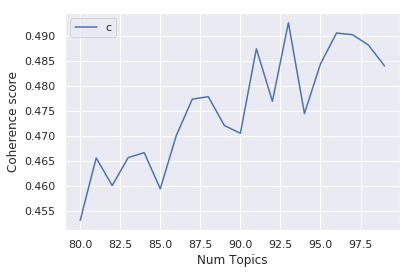

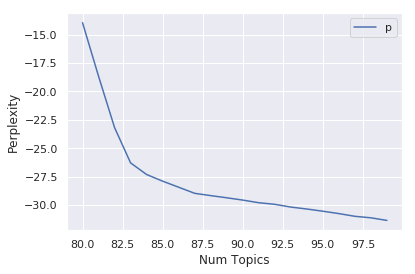

In [9]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute coherence for various number of topics

    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Plots coherence score over number of topics
    """
    tick = time()
    coherence_values = []
    model_list = []
    perplexity_values = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, 
                       id2word=dictionary, 
                       num_topics=num_topics, 
                       alpha=0.001, 
                       minimum_probability=0.4,
                       iterations=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        perplexity_values.append(model.log_perplexity(common_corpus))
        print('At {} of {}'.format(num_topics, limit))
    print('Process took {} min'.format((time()-tick)/60))
        
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

    plt.plot(x, perplexity_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Perplexity")
    plt.legend(("perplexity"), loc='best')
    plt.show()

compute_coherence_values(common_dictionary, common_corpus, corpus, limit=100, start=80, step=1)

Subsequent visual evaluation of the model shows that model perplexity in this case is more reliable:
chose the point where curve starts to flatten (elbow) - this will give the best result

In [6]:
lda = LdaModel(common_corpus, 
               num_topics=83, 
               id2word=common_dictionary, 
               alpha=0.001, 
               random_state=123, 
               minimum_probability=0.4,
               per_word_topics=True,
               iterations=70)

# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='c_v')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score c_v: ', coherence_lda)

# Compute Coherence Score using u-mass
coherence_model_lda = CoherenceModel(model=lda, texts=corpus, dictionary=common_dictionary, coherence='u_mass')

coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score u-mass: ', coherence_lda)

perplexity = lda.log_perplexity(common_corpus)
print('Model perplexity: ', perplexity)

ldavis_prepared = pyLDAvis.gensim.prepare(lda, common_corpus, common_dictionary)

pyLDAvis.display(ldavis_prepared)

Coherence Score c_v:  0.45796973506259603
Coherence Score u-mass:  -13.909508546695157
Model perplexity:  -26.329005978791248


/home/franzi/miniconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf

- A topic in LDA is a multinomial distribution over the (typically thousands of) terms in the vocabulary of the corpus. 

In [131]:
def format_topics_sentences(ldamodel, corpus, texts):
    
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=common_corpus, texts=corpus)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']


# reindex the initial dataframe, make list of initial df and topics df and concatenate both
all_data_reindexed = all_data.loc['2018-08-07':"2018-08-08"].reset_index(drop=True)
df_list = [df_dominant_topic,all_data_reindexed]
full_df = pd.concat(df_list, axis=1)
# make the resulting dataframe datetime indexed again and throw away unwanted columns
full_df.index = full_df['created_at']
full_df = full_df.drop(['stemmed', 'tags', 'parties', 'full_text', 'created_at', 'mentions'], axis=1)
# show
full_df.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,clean_text,user_id
created_at,,,,,,,
2018-08-07 00:02:20,0,75.0,0.0187,"besuch, blaue, fuss, plan, ansicht, katastroph...","[sami, rundfluege, migranten, fluechtlinge, we...",Fuer ein Interview zur Migration aus Afr...,872422743597346825
2018-08-07 00:03:00,1,77.0,0.0140,"lindner, christian, perverse, wagenknecht, ram...","[noafd, schreiben, argumente, liefern, waehlen]",Wir muessen fluechten Hoppla wohin d...,811084902858944512
2018-08-07 00:06:59,2,27.0,0.0189,"liberale, and, klingt, verdienen, frieden, bra...","[kenne, reps, baden, wuerttemberg, trifft]",Mal so nebenbei Ganz zufaellig a...,1024144288488271872
2018-08-07 00:09:43,3,74.0,0.0206,"farbe, blau, oepnv, pseudo, willkommenskultur,...","[drittens, kauf, nehmen, ungleich, bergsteige,...",So wie du Passt,3188267323
2018-08-07 00:12:40,4,0.0,0.0128,"roth, rahmen, draussen, claudia, nutzt, krass,...","[werte, verstehen, afdwirkt]",Ein Teil dieser Chabolas wuerde die AfD ...,4377601889


In [132]:
topic_counts = full_df.groupby(full_df.index.date)['Dominant_Topic'].value_counts().reset_index(name='counts')

In [133]:
topic_counts = topic_counts.set_index(pd.DatetimeIndex(topic_counts['level_0']))

In [134]:
topic_counts.head()

,level_0,Dominant_Topic,counts
level_0,,,
2018-08-07,2018-08-07,0.0,330
2018-08-07,2018-08-07,22.0,211
2018-08-07,2018-08-07,36.0,202
2018-08-07,2018-08-07,52.0,202
2018-08-07,2018-08-07,63.0,200


In [135]:
topic_counts.index.unique()

DatetimeIndex(['2018-08-07', '2018-08-08'], dtype='datetime64[ns]', name='level_0', freq=None)

In [136]:
def topic_plot(df, n_horizontal, n_vertical):
    dates = df.index.unique()
    
    fig = plt.figure()
    fig, ax = plt.subplots(n_horizontal, n_vertical)

    
    for i, date in enumerate(dates):
        ax[i].bar(df.loc['{}'.format(date), 'Dominant_Topic'], df.loc['{}'.format(date), 'counts'])
        plt.xlabel('Topic number')
        plt.ylabel('Mention count')

<Figure size 432x288 with 0 Axes>

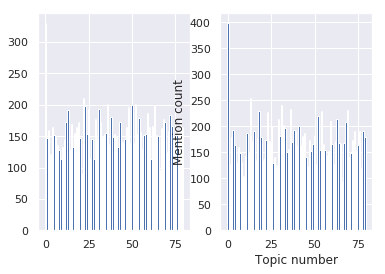

In [141]:
topic_plot(topic_counts, 1, 2)

<BarContainer object of 40 artists>

<Figure size 432x288 with 0 Axes>

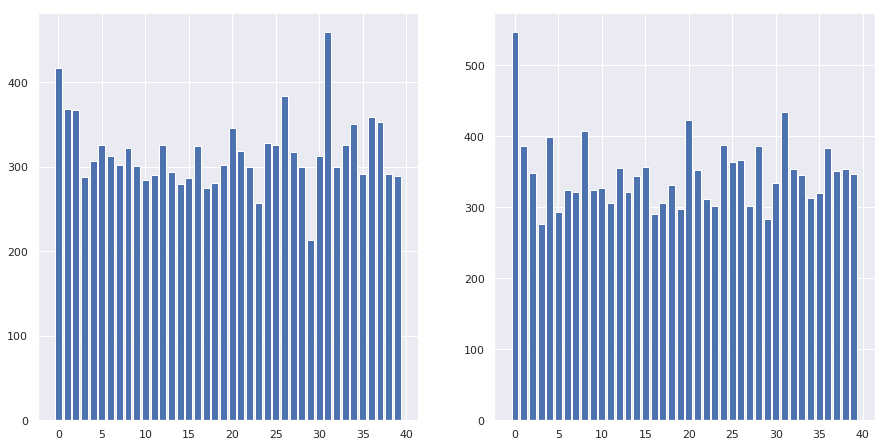

In [106]:
fig = plt.figure()
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
ax[0].bar(topic_counts.loc['2018-08-07', 'Dominant_Topic'], topic_counts.loc['2018-08-07', 'counts'])
ax[1].bar(topic_counts.loc['2018-08-08', 'Dominant_Topic'], topic_counts.loc['2018-08-08', 'counts'])

AttributeError: 'Series' object has no attribute 'plt'

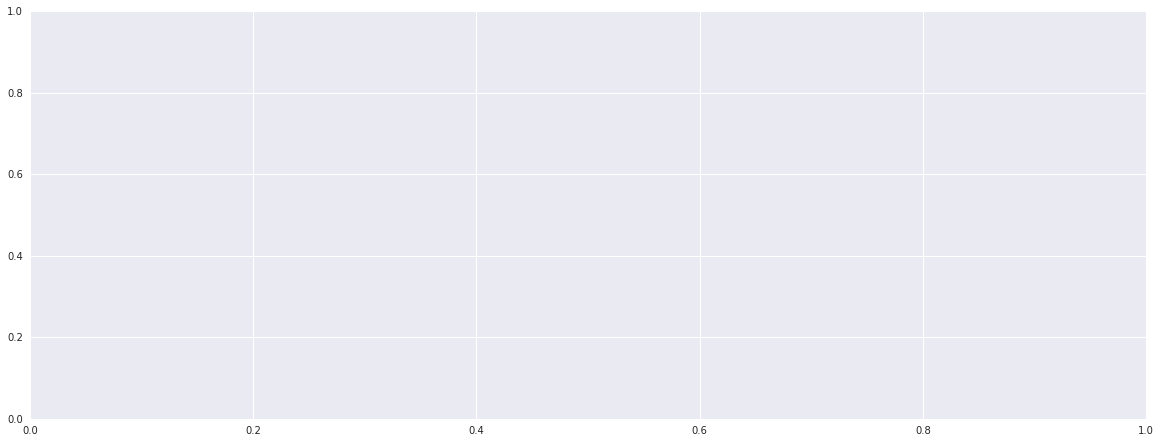

In [116]:
plt.figure(figsize=(20, 7.5))
fig, ax = plt.subplot()
full_df.loc[:, 'Dominant_Topic'].resample('D').count().bar(ax=ax)
plt.legend()
plt.ylabel("Number of tweets per hour")
plt.xlabel("Date") 
# ax.grid(axis='both')
plt.show()

In [113]:
test_count = full_df['Dominant_Topic'].apply(pd.value_counts)

TypeError: 'float' object is not iterable

In [57]:
user_text = df_part.loc[:, ['user_id', 'clean_text']]
user_text.reset_index()
user_text = pd.DataFrame(user_text.groupby(user_text['user_id'])['clean_text'].apply(lambda x: '. '.join(x.astype(str))))

user_tags = df_part.loc[:, ['user_id', 'topics']]
user_tags.reset_index()
user_tags = pd.DataFrame(user_tags.groupby(user_tags['user_id'])['tags'].apply(lambda x: '. '.join(x.astype(str))))

user_tweetcount = pd.DataFrame(df_part.loc[:, 'user_id'].groupby(df_part['user_id']).count())

user_dflist = [user_text, user_tags, user_tweetcount]

NameError: name 'df_part' is not defined

In [35]:
test_df = pd.read_pickle('../Data/all_data_lda.pickle')

In [36]:
test_df.head()

,created_at,full_text,tags,mentions,clean_text,parties,stemmed,user_id
created_at,,,,,,,,
2018-08-02 00:00:14,2018-08-02 00:00:14,@BILD Für Sami A macht man Rundflüge. gute Mig...,"[CSU, AfD, Bild, CSU, Bild, CSU, SPD, FDP, AFD...",[BILD],Fuer Sami A macht man Rundfluege gute ...,"[AfD, SPD, CSU, FDP]",fuer sami a macht man rundflueg gut m...,884513792062881794
2018-08-02 00:00:32,2018-08-02 00:00:32,@bembelpix @AfD_Hessen NoAFD schreiben aber ke...,[],"[bembelpix, AfD_Hessen]",NoAFD schreiben aber keine Argumente li...,[AfD],noafd schreib aber kein argument lief ...,702527680722419712
2018-08-02 00:00:32,2018-08-02 00:00:32,RT @Walnusskipferl: @AssetsKater72 @dr_ecksack...,[],"[Walnusskipferl, AssetsKater72, dr_ecksack_, i...",Ich kenne nur die REPs Baden Wuer...,[],ich kenn nur die reps bad wuertte...,3438043463
2018-08-02 00:01:33,2018-08-02 00:01:33,@NeotherealNeo @vonduessel @AfD @AndreasKalbit...,[],"[NeotherealNeo, vonduessel, AfD, AndreasKalbitz]",Drittens in kauf nehmen ist ungleich ...,[AfD],dritt in kauf nehm ist ungleich woll...,846319908254367744
2018-08-02 00:02:08,2018-08-02 00:02:08,Damit wir die Werte #AfD besser verstehen. #Af...,"[AfD, AfDwirkt]",[],Damit wir die Werte AfD besser verstehe...,[AfD],damit wir die wert afd bess versteh ...,165708897
